In [1]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterator, *args, **kwargs):
        return iterator
import os, sys, glob, warnings, glob    
import numpy as np
import scipy as sp
from scipy import constants
from pylab import *
import joblib
import importlib
from importlib import reload
sys.path.append("/home/owhgabri/My_GitHub/MATHUSLA_JupyterNoteBooks/tracker")
sys.path.insert(1, "/home/owhgabri/My_GitHub/MATHUSLA_JupyterNoteBooks/tracker")
os.chdir('/home/owhgabri/My_GitHub/pyTracker')
print(os.getcwd())
print(joblib.__version__)

/home/owhgabri/My_GitHub/pyTracker
1.4.2


In [2]:
import scipy
import copy as cp

# ROOT
import ROOT as root

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections, colors, transforms

%matplotlib inline
%config InlineBackend.figure_format='retina'
# %matplotlib widget

import pprint

Welcome to JupyROOT 6.26/14


In [3]:
import kalmanfilter as KF
import utilities as Util
import trackfinder as TF
import vertexfinder as VF
import datatypes
from datatypes import *

reload(TF)
reload(VF)
reload(Util)

<module 'utilities' from '/home/owhgabri/My_GitHub/MATHUSLA_JupyterNoteBooks/tracker/utilities.py'>

### Defining Useful Functions ### 

In [4]:
x_mod_starts = [-1950, -950, 50, 950, 1050]
y_layer_starts = [8550, 8631.6, 9730, 9811.6, 9893.2, 9974.8, 10056.4, 10138]
z_mod_starts = [7000, 8000, 9000, 10000]
z_wall_starts = [10900, 10981.6, 11063.2, 11144.8, 11226.4, 11308]
y_wall_top =  y_layer_starts[4]
beam_dim = 10
mod_length = 900

steel_height=3 # cm
Box_IP_Depth=8547 # cm   
c = 29.979

wall_floor1 = (7000,8633.2)
wall_floor2 = (7000,8551.6)
wallMid1 = 6896.6
wallMid2 = 6998.2
floorMid1 = 8550.8
floorMid2 = 8632.4

IP = (0,0,0)

y_bottoms = [8550, 8631.6]
z_fronts = [6895.8, 6997.4]
x_lims = (-1950, 1950)
thickness = 1.6

In [5]:
def MakeLayers():
    """
    Returns a list of the layer modules of 
    the form
    ((x_min, x_max),(y_min,y_max),(z_min, z_max))
    """
    layers = []
    for i in range(2, len(y_layer_starts)):
        for j in range(len(x_mod_starts)):
            for k in range(len(z_mod_starts)):
                y_min = y_layer_starts[i]; y_max = y_layer_starts[i] + thickness
                x_min = x_mod_starts[j]; x_max = x_mod_starts[j] + mod_length
                z_min = z_mod_starts[k]; z_max = z_mod_starts[k] + mod_length
                layers.append(np.array(((x_min, x_max),(y_min,y_max),(z_min,z_max))))
    return layers

def MakeBacks():
    """
    Returns a list of the back modules of 
    the form
    ((x_min, x_max),(y_min,y_max),(z_min, z_max))
    """
    backs = []
    y_min = back_top - mod_length; y_max = back_top
    for j in range(len(x_mod_starts)):
        for k in range(len(z_wall_starts)):
            x_min = x_mod_starts[j]; x_max = x_mod_starts[j] + mod_length
            z_min = z_wall_starts[k]; z_max = z_wall_starts[k] + thickness
            backs.append(np.array(((x_min, x_max),(y_min,y_max),(z_min,z_max))))
    return backs

def MakeWalls():
    """
    Returns a list of the hermetic walls of the form
    ((x_min, x_max),(y_min,y_max),(z_min, z_max))
    """
    walls = []
    y_min = y_layer_starts[0]; y_max = back_top
    x_min = x_mod_starts[0]; x_max = x_mod_starts[-1] + mod_length
    for i in range(len(front_wall_starts)):
        z_min = front_wall_starts[i]; z_max = front_wall_starts[i] + thickness
        walls.append(np.array(((x_min,x_max),(y_min,y_max),(z_min,z_max))))
    return walls

def MakeFloors():
    """
    Returns a list of the hermetic walls of the form
    ((x_min, x_max),(y_min,y_max),(z_min, z_max))
    """
    floors = []
    z_min = z_mod_starts[0]; z_max = z_mod_starts[-1] + mod_length
    x_min = x_mod_starts[0]; x_max = x_mod_starts[-1] + mod_length
    for i in range(n_floors):
        y_min = y_layer_starts[i]; y_max = y_layer_starts[i] + thickness
        floors.append(np.array(((x_min,x_max),(y_min,y_max),(z_min,z_max))))
    return floors
    
def MakeBeams():
    """
    Returns a list with beams of the form 
    ((x_min, x_max),(y_min,y_max),(z_min, z_max))
    """
    beams = []
    for i in range(len(y_layer_starts) - 1):
        for j in range(len(x_mod_starts)):
            for k in range(len(z_mod_starts)):
                y_min = y_layer_starts[i] + thickness; y_max = y_layer_starts[i+1]
                
                x_min = x_mod_starts[j]; x_max = x_mod_starts[j] + beam_dim
                z_min = z_mod_starts[k]; z_max = z_mod_starts[k] + beam_dim
                beams.append(np.array(((x_min, x_max),(y_min,y_max),(z_min,z_max))))
                
                x_min = x_mod_starts[j]; x_max = x_mod_starts[j] + beam_dim
                z_min = z_mod_starts[k] + mod_length - beam_dim; z_max = z_mod_starts[k] + mod_length
                beams.append(np.array(((x_min, x_max),(y_min,y_max),(z_min,z_max))))

                x_min = x_mod_starts[j] + mod_length - beam_dim; x_max = x_mod_starts[j] + mod_length
                z_min = z_mod_starts[k]; z_max = z_mod_starts[k] + beam_dim
                beams.append(np.array(((x_min, x_max),(y_min,y_max),(z_min,z_max))))

                x_min = x_mod_starts[j] + mod_length - beam_dim; x_max = x_mod_starts[j] + mod_length
                z_min = z_mod_starts[k] + mod_length - beam_dim; z_max = z_mod_starts[k] + mod_length
                beams.append(np.array(((x_min, x_max),(y_min,y_max),(z_min,z_max))))
    return beams

def MakeGround():
    """
    Returns a list with the ground of the form
    ((x_min, x_max),(y_min,y_max),(z_min, z_max))
    """
    ground = []
    x_min = -9999999; x_max = 9999999
    y_min = -9999999; y_max = 8547
    z_min = -9999999; z_max = 9999999
    ground.append(np.array(((x_min,x_max), (y_min,y_max),(z_min,z_max))))
    return ground


def MakeMaterials():
    """
    Returns all the materials concatenated together
    """
    beams = MakeBeams()
    layers = MakeLayers()
    backs = MakeBacks()
    walls = MakeWalls()
    floors = MakeFloors()
    ground = MakeGround()
    return np.concatenate((beams,layers,backs,walls,floors, ground))


def GetResidual(vertex, rectangle):
    """
    Get the distance between the vertex and a rectangle
    The rectangle is of the form 
    ((x_min, x_max),(y_min,y_max),(z_min, z_max))
    """
    x_min, x_max = rectangle[0]
    y_min, y_max = rectangle[1]
    z_min, z_max = rectangle[2]
    x_v,y_v,z_v = np.array((vertex.x0, vertex.y0, vertex.z0))
    x_clam = max(x_min, min(x_v, x_max))
    y_clam = max(y_min, min(y_v, y_max))
    z_clam = max(z_min, min(z_v, z_max))
    return np.array(((x_v - x_clam), (y_v - y_clam), (z_v - z_clam)))


def GetChi2(vertex, rectangle):
    """
    Get the chi2 between the vertex and the rectangle
    """
    res = GetResidual(vertex, rectangle)
    trimmed_cov = np.delete(vertex.cov, 3, 0)
    trimmed_cov = np.delete(trimmed_cov, 3, 1)
    return res.T@np.linalg.inv(trimmed_cov)@res


def MinDistance(vertex):
    """
    Returns the minimum distance to a material
    """
    materials = MakeMaterials()
    min_dist = None
    for material in materials:
        res = GetResidual(vertex, material)
        dist = np.sqrt(res[0]**2 + res[1]**2 + res[2]**2)
        if min_dist is None or dist < min_dist:
            min_dist = dist
    return min_dist

def MinChi2(vertex):
    """
    Returns the minimum chi2 of the vertex
    """
    materials = MakeMaterials()
    min_chi2 = None
    for material in materials:
        chi2 = GetChi2(vertex, material)
        if min_chi2 is None or chi2 < min_chi2:
            min_chi2 = chi2
    return min_chi2
    

# DataFiles #

In [6]:
data_top_dir = f"/home/owhgabri/My_GitHub/data/Reconstruction/10xCosmicBackground"
pathList=[]

for rootFile, dirs, files in os.walk(data_top_dir):
    for filename in files:
        if ".pkl" in filename:
            pathList.append(os.path.join(rootFile, filename))


print(len(pathList))

187


# Vertex Positions #

## Scatter Plot ##

Number of vertices inside the detector: 3864


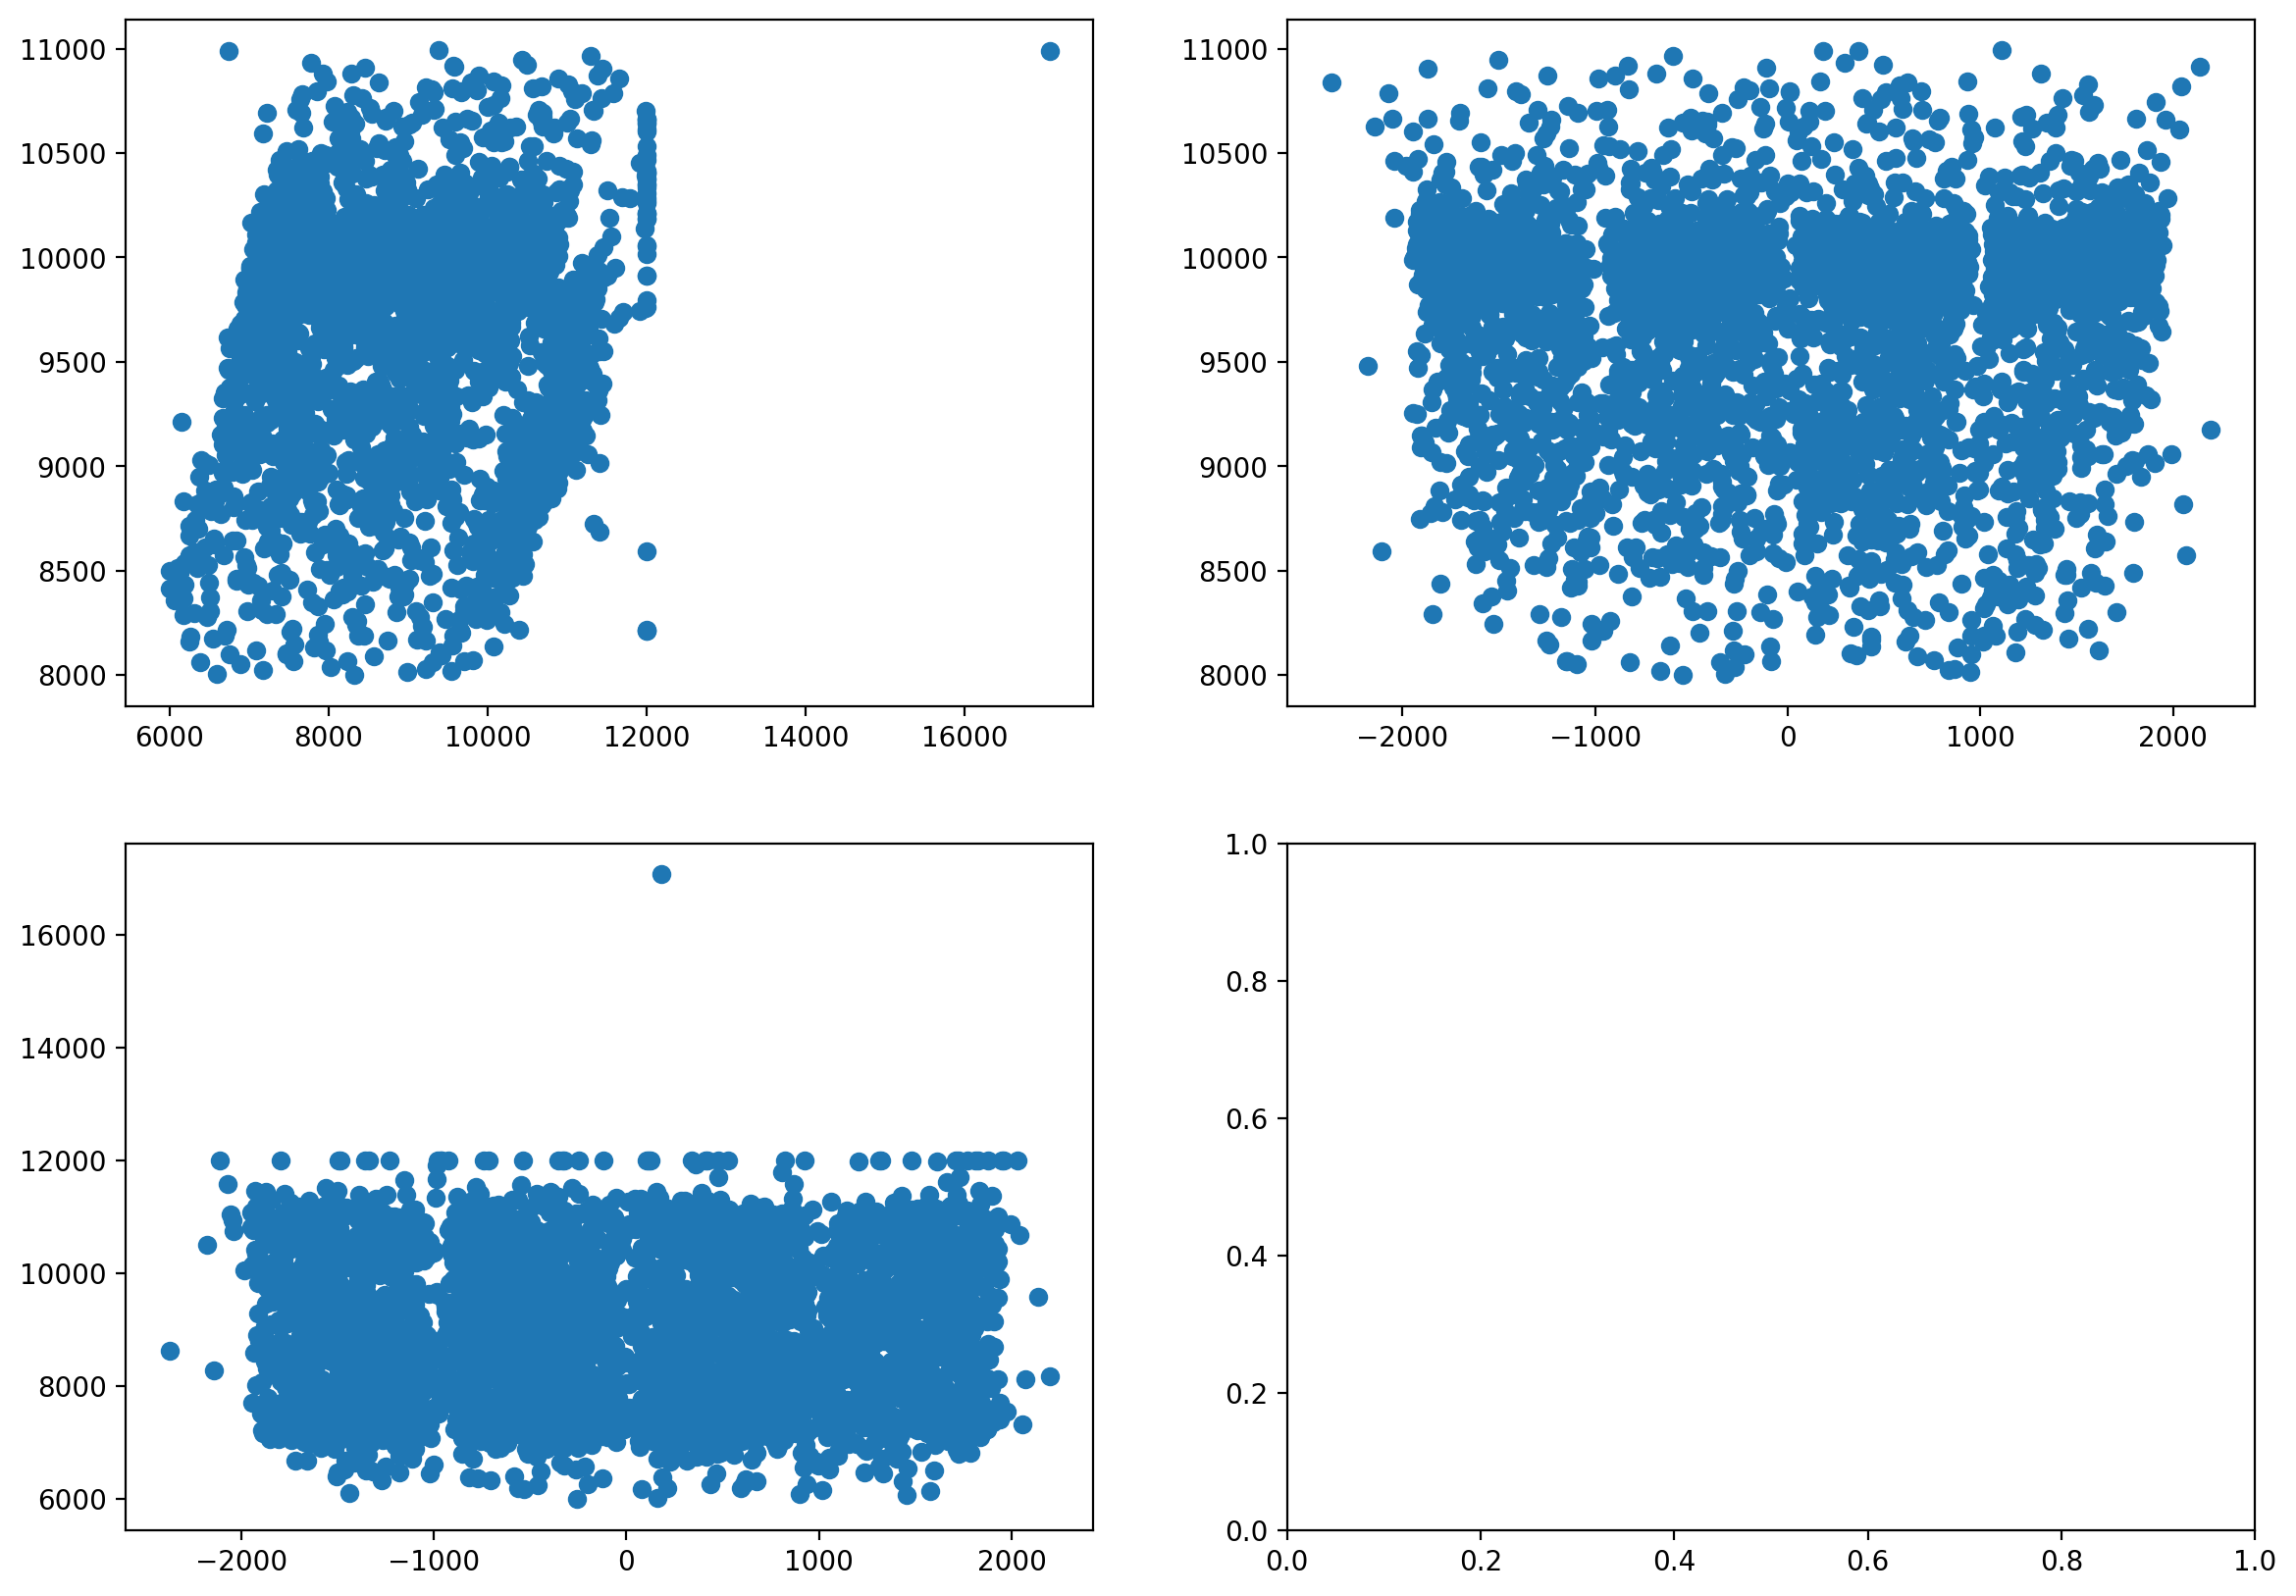

In [7]:
fig,axs=plt.subplots(2,2,figsize=(14,10))
axs=axs.flatten().tolist()

points = []
for f in pathList:
    events=joblib.load(f)
    file_vertices = events["vertices"]
    for i in range(len(file_vertices)):
        vertices = file_vertices[i]
        if len(vertices) == 0:
            continue
        for vertex in vertices:
            # Inside the detector
            if vertex.x0 < -2500 or vertex.x0 > 2500 or \
            vertex.y0 < 8000 or vertex.y0 > 11000 or \
            vertex.z0 < 6000:
                continue
            points.append((vertex.x0, vertex.y0, vertex.z0))
print("Number of vertices inside the detector:", len(points))
x,y,z = np.array(points).T

axs[0].scatter(z,y)
axs[1].scatter(x,y)
axs[2].scatter(x,z)



In [19]:
v_s = []
for p in points:
    if p[0] < -2500 or p[0] > 2500 or \
    p[1] < 8000 or p[1] > 11000 or \
    p[2] < 6000:
        continue
    v_s.append(p)

x,y,z = np.array(v_s).T

## Density Distribution ##

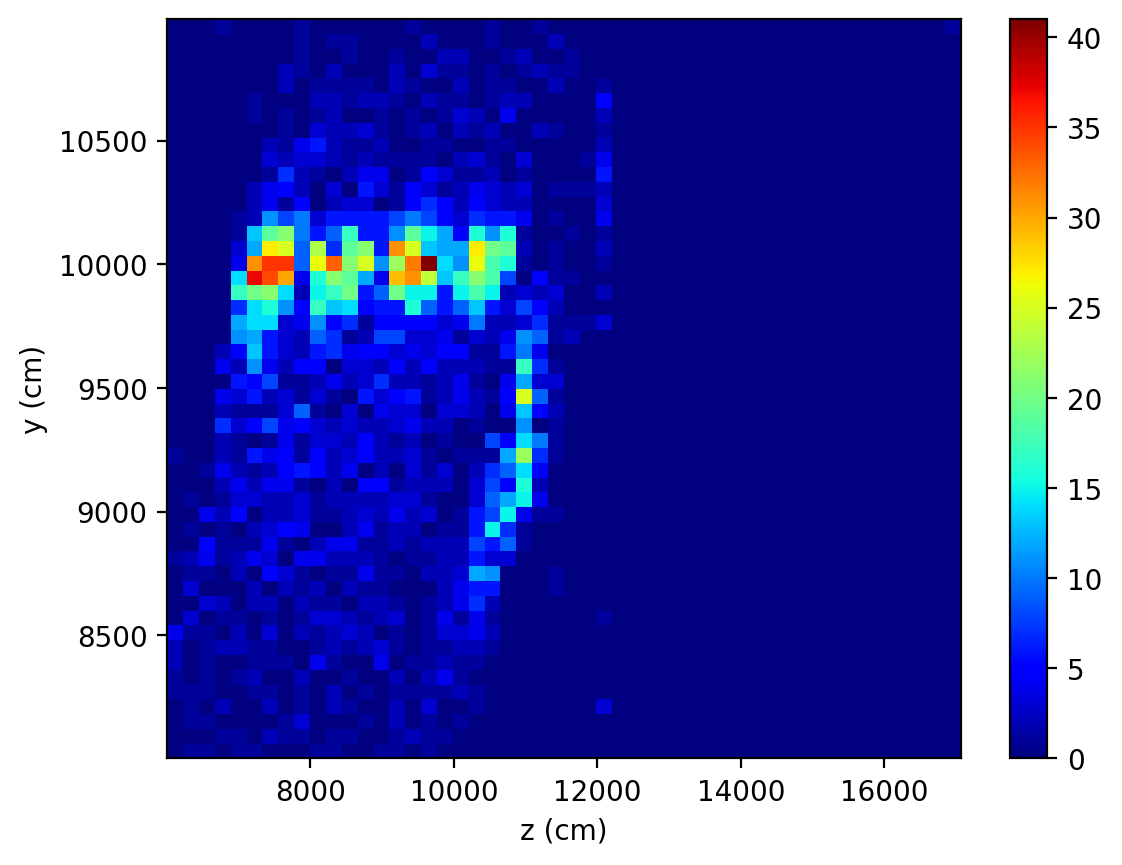

In [20]:
plt.hist2d(z, y, bins=(50, 50), cmap=plt.cm.jet)
plt.xlabel("z (cm)")
plt.ylabel("y (cm)")
plt.colorbar()


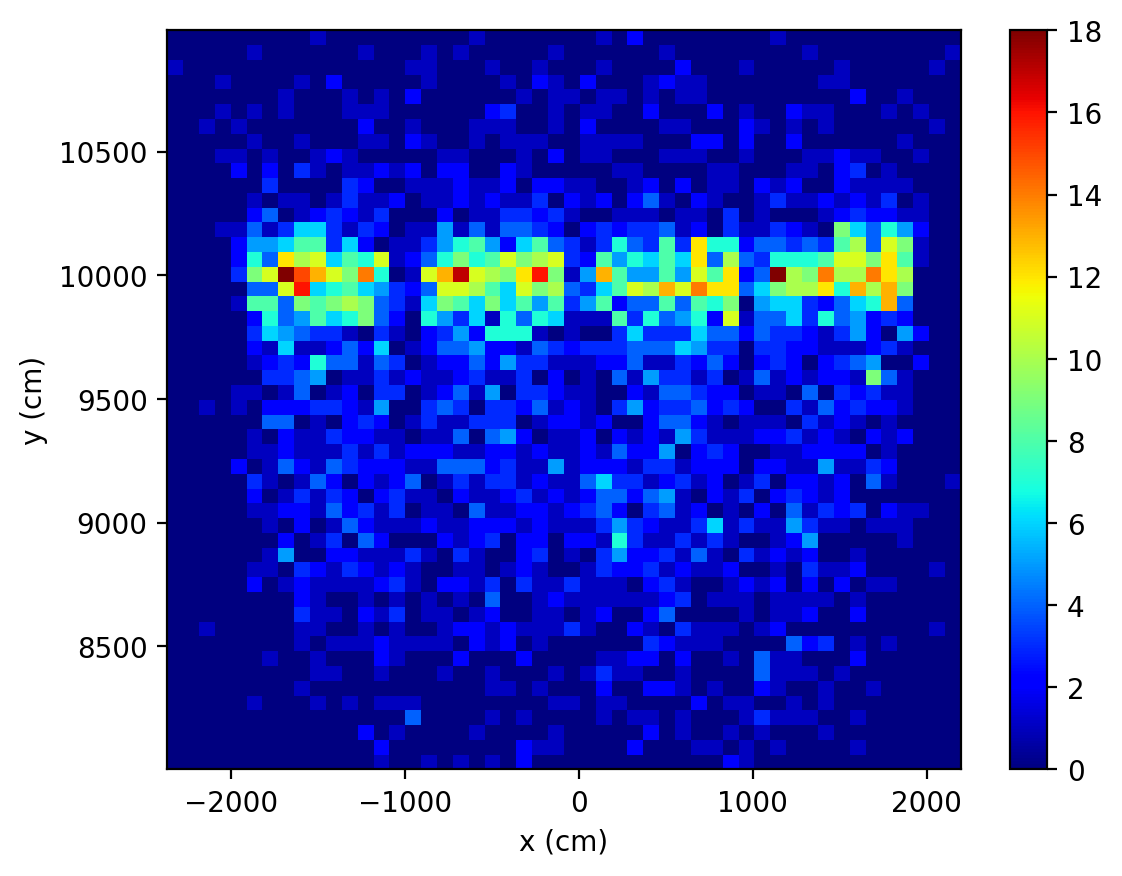

In [21]:
plt.hist2d(x, y, bins=(50, 50), cmap=plt.cm.jet)
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.colorbar()

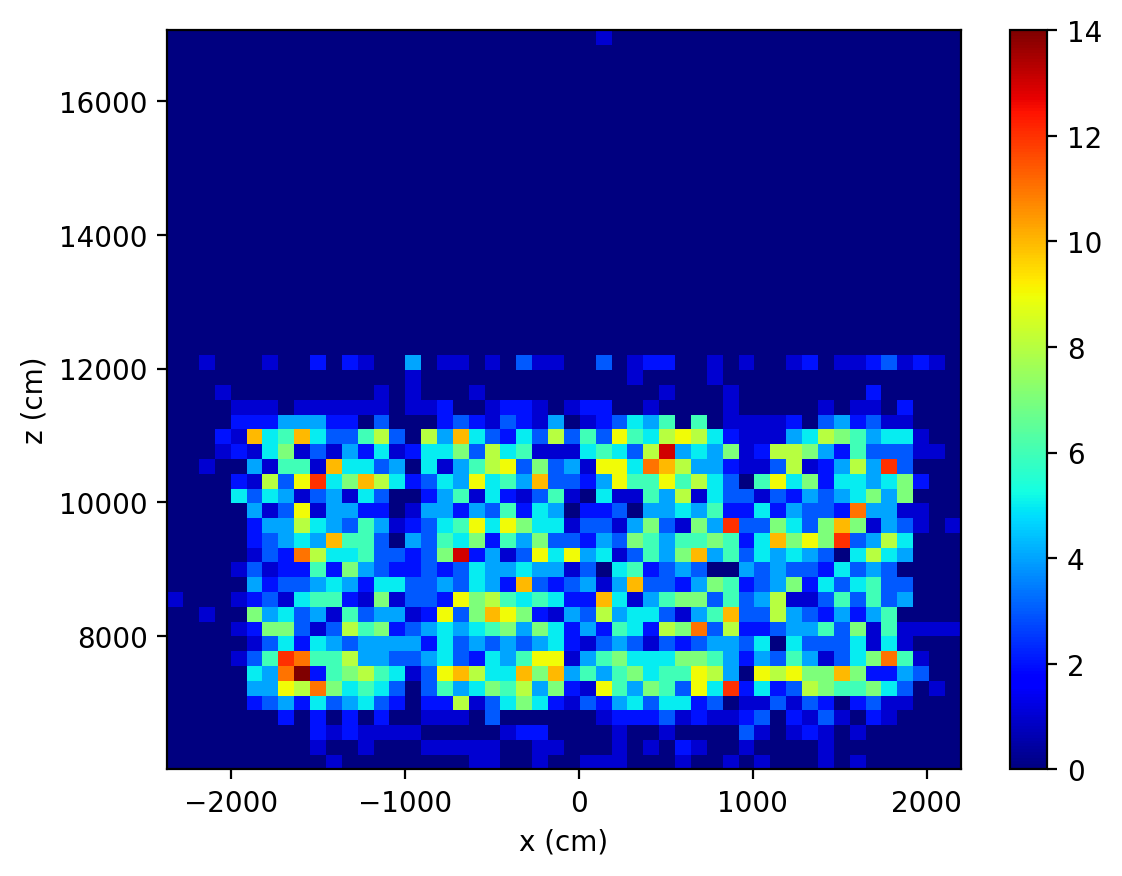

In [22]:
plt.hist2d(x, z, bins=(50, 50), cmap=plt.cm.jet)
plt.xlabel("x (cm)")
plt.ylabel("z (cm)")
plt.colorbar()

# Vertex Coordinate Distribution #

Number of vertices inside the detector: 4389


Text(0.5, 1.0, 'z')

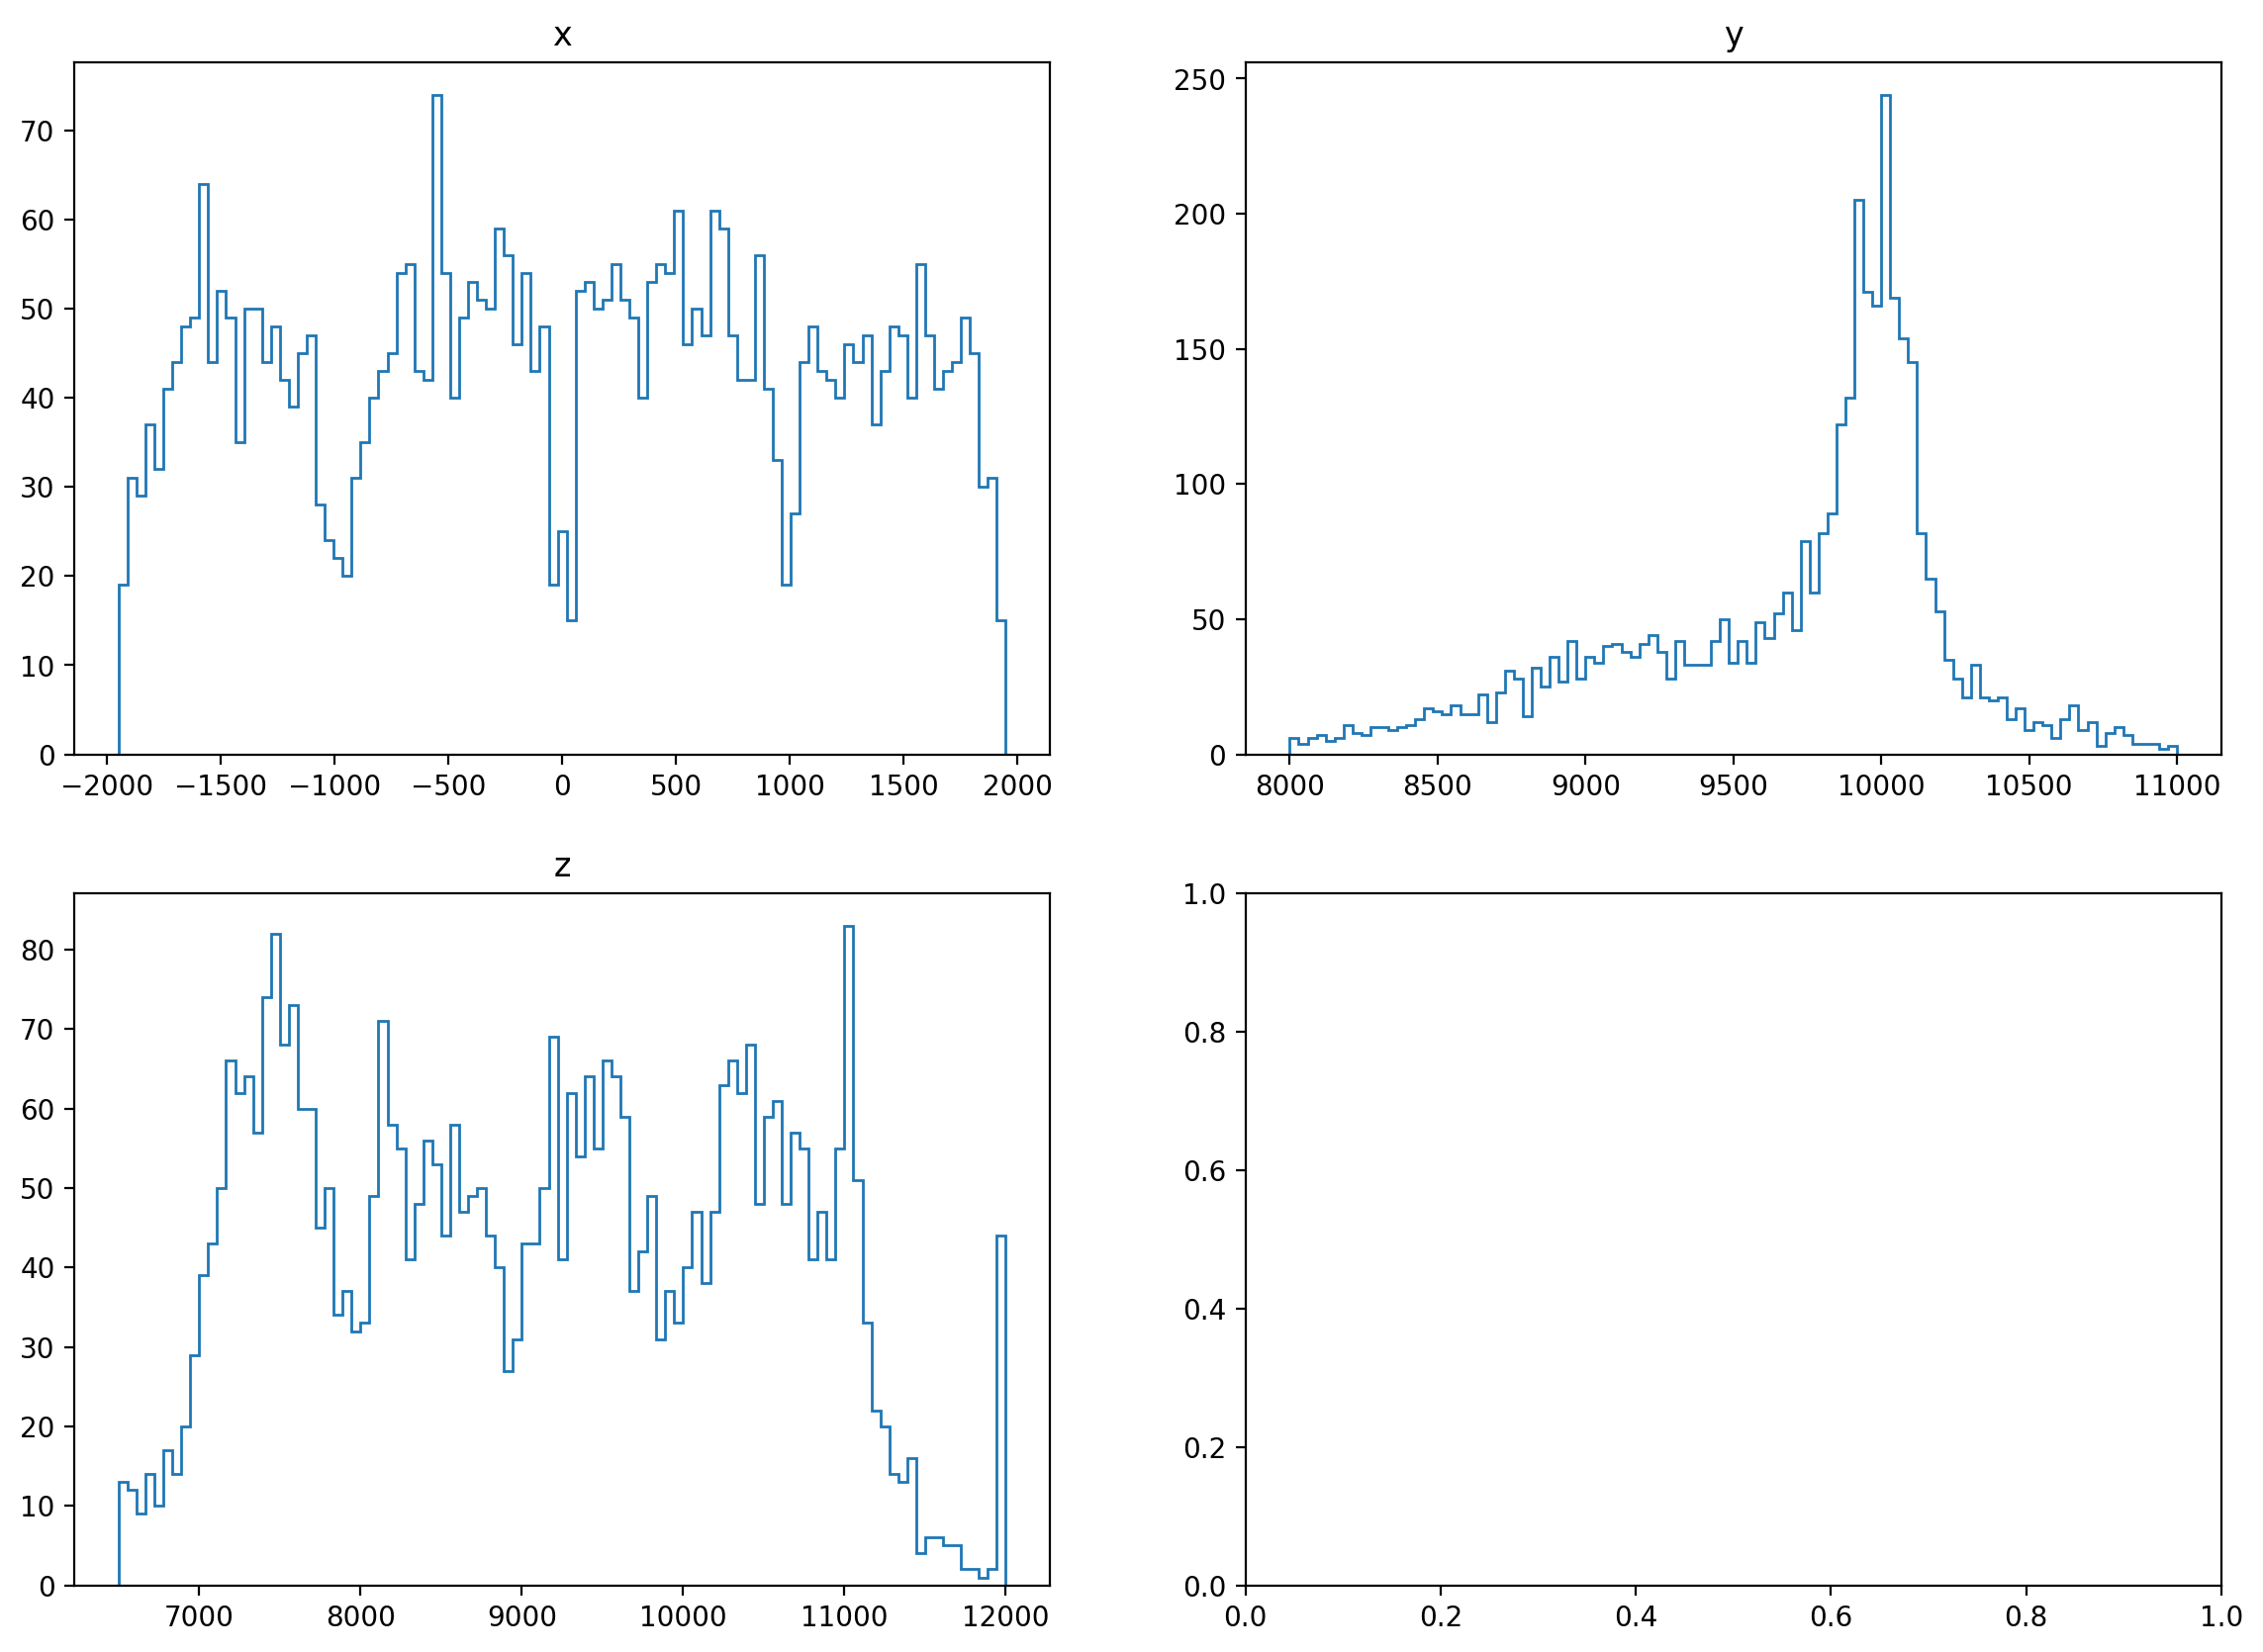

In [11]:
fig,axs=plt.subplots(2,2,figsize=(14,10))
axs=axs.flatten().tolist()

points = []
for f in pathList:
    events=joblib.load(f)
    file_vertices = events["vertices"]
    for i in range(len(file_vertices)):
        vertices = file_vertices[i]
        if len(vertices) == 0:
            continue
        for vertex in vertices:
            points.append((vertex.x0, vertex.y0, vertex.z0))
print("Number of vertices inside the detector:", len(points))
x,y,z = np.array(points).T
xCounts,xbins = np.histogram(x, bins=np.linspace(-1950, 1950, 100))
yCounts,ybins = np.histogram(y, bins=np.linspace(8000,11000, 100))
zCounts,zbins = np.histogram(z, bins=np.linspace(6500, 12000, 100))
axs[0].stairs(xCounts,xbins)
axs[0].set_title("x")
axs[1].stairs(yCounts,ybins)
axs[1].set_title("y")
axs[2].stairs(zCounts,zbins)
axs[2].set_title("z")


# Vertex Error Distribution #

In [26]:
points = []
nVertices = 0
for f in pathList:
    events=joblib.load(f)
    file_vertices = events["vertices"]
    for i in range(len(file_vertices)):
        vertices = file_vertices[i]
        nVertices += len(vertices)
        if len(vertices) == 0:
            continue
        for vertex in vertices:
            # Inside the detector
            points.append((np.sqrt(vertex.cov[0][0]), np.sqrt(vertex.cov[1][1]), np.sqrt(vertex.cov[2][2])))


Text(0.5, 1.0, 'Distance error')

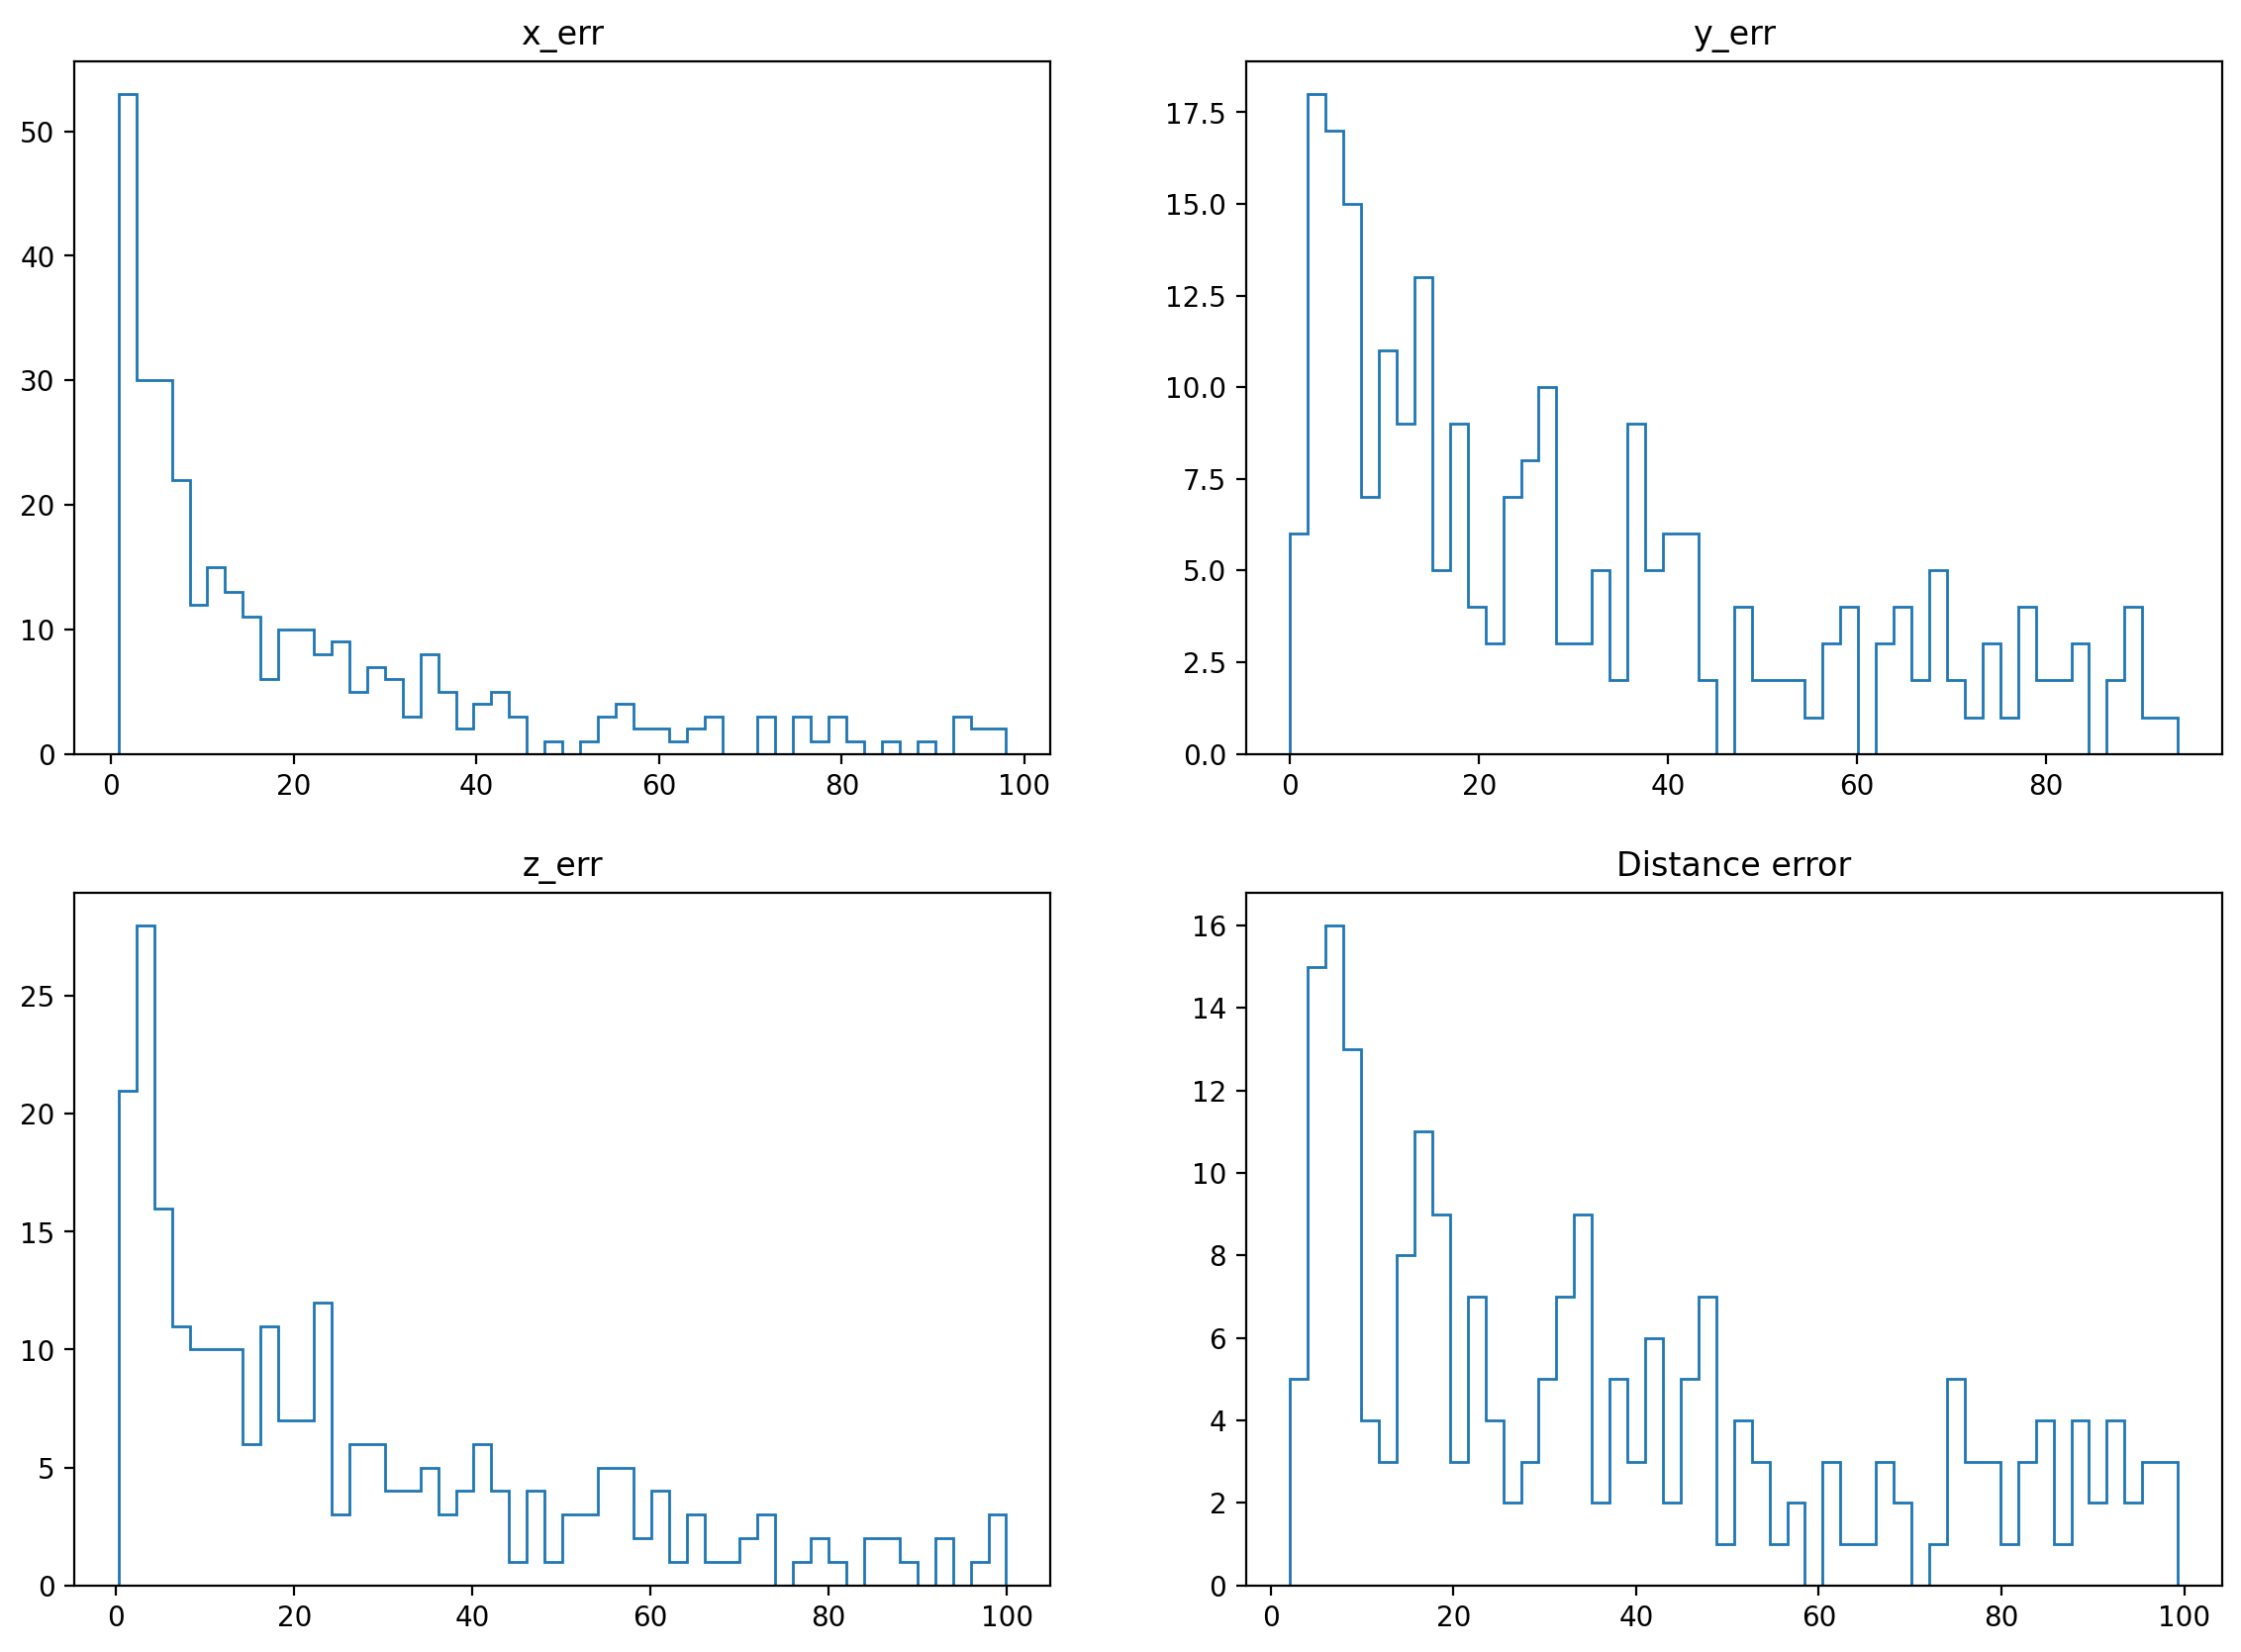

In [27]:
fig,axs=plt.subplots(2,2,figsize=(14,10))
axs=axs.flatten().tolist()

x,y,z = np.array(points).T
d = np.sqrt(x**2 + y**2 + z**2)
zoomx = []; zoomy =[]; zoomz=[]
zoomd = []
for i in range(len(x)):
    if x[i] < 100:
        zoomx.append(x[i])
    if y[i] < 100:
        zoomy.append(y[i])
    if z[i] < 100:
        zoomz.append(z[i])
    if d[i] < 100:
        zoomd.append(d[i])
xCounts,xbins = np.histogram(zoomx, bins=50)
yCounts,ybins = np.histogram(zoomy, bins=50)
zCounts,zbins = np.histogram(zoomz, bins=50)
dCounts,dbins = np.histogram(zoomd, bins=50)
axs[0].stairs(xCounts,xbins)
axs[0].set_title("x_err")
axs[1].stairs(yCounts,ybins)
axs[1].set_title("y_err")
axs[2].stairs(zCounts,zbins)
axs[2].set_title("z_err")
axs[3].stairs(dCounts,dbins)
axs[3].set_title("Distance error")

In [33]:
dists = [0.01,1,2,5,10,25,50,100]
n = []
for i in range(len(dists)):
    n.append(0)
for err in d:
    for i in range(len(dists)):
        if err > dists[i]:
            n[i]+=1
for i in range(len(n)):
    print("Percentage of data with an error greater than " + str(dists[i]) + " cm:", n[i]/nVertices)

Percentage of data with an error greater than 0.01 cm: 1.0
Percentage of data with an error greater than 1 cm: 1.0
Percentage of data with an error greater than 2 cm: 1.0
Percentage of data with an error greater than 5 cm: 0.9601139601139601
Percentage of data with an error greater than 10 cm: 0.8603988603988604
Percentage of data with an error greater than 25 cm: 0.7207977207977208
Percentage of data with an error greater than 50 cm: 0.5584045584045584
Percentage of data with an error greater than 100 cm: 0.3903133903133903


# Vertex Average Beta vs Error #

In [8]:
points = []
betas = []
nVertices = 0
for f in pathList:
    events=joblib.load(f)
    file_vertices = events["vertices"]
    file_tracks = events["tracks"]
    for i in range(len(file_vertices)):
        vertices = file_vertices[i]
        tracks = file_tracks[i]
        nVertices += len(vertices)
        if len(vertices) == 0:
            continue
        for vertex in vertices:
            v_tracks = []
            beta = 0
            for t_index in vertex.tracks:
                v_tracks.append(tracks[t_index])
            for track in v_tracks:
                v = np.sqrt((track.Ax/track.At)**2 + (track.Ay/track.At)**2 + (track.Az/track.At)**2)
                beta += v/c
            beta = beta/len(vertex.tracks)
            betas.append(beta)
            points.append((np.sqrt(vertex.cov[0][0]), np.sqrt(vertex.cov[1][1]), np.sqrt(vertex.cov[2][2])))


Text(0, 0.5, 'Beta')

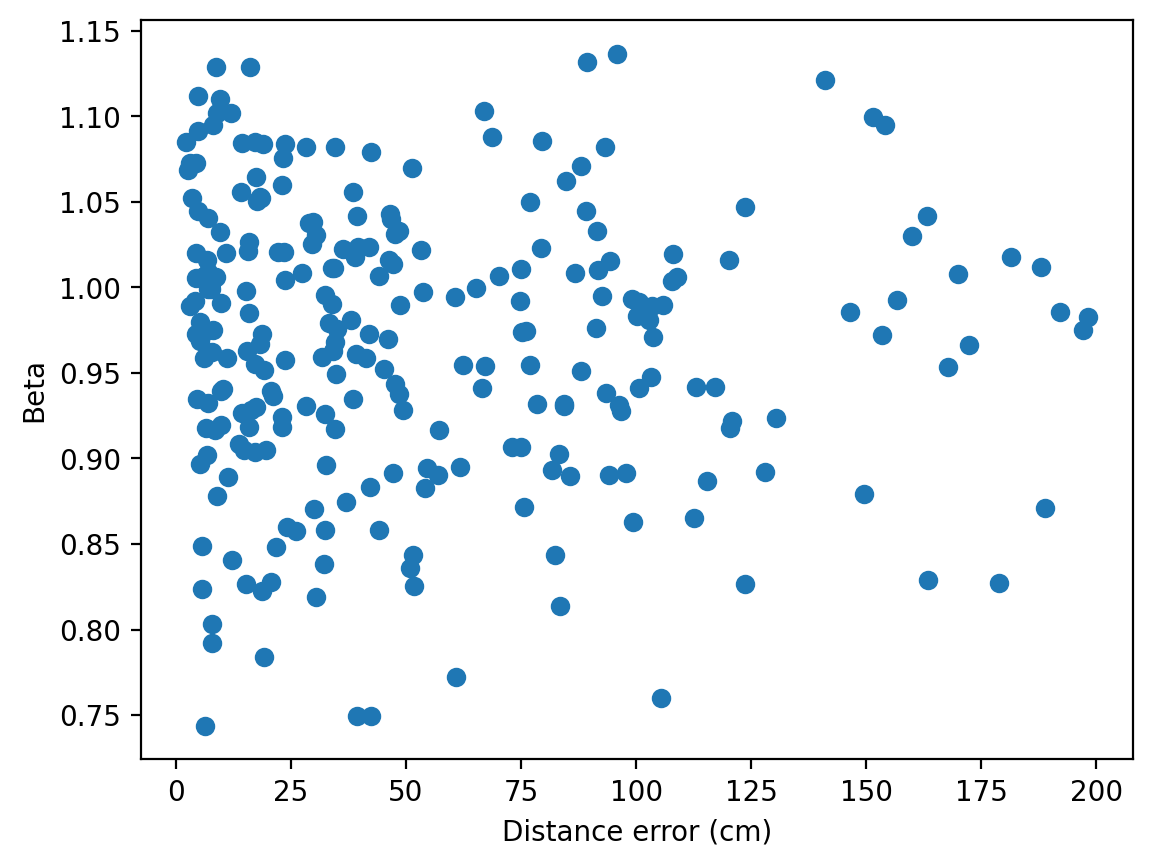

In [16]:
dists = []
trimmed_betas = []
for i in range(len(betas)):
    dist = (np.sqrt(points[i][0]**2 + points[i][1]**2 + points[i][2]**2))
    if dist < 200:
        dists.append(dist)
        trimmed_betas.append(betas[i])
        
plt.scatter(dists, trimmed_betas)
plt.xlabel("Distance error (cm)")
plt.ylabel("Beta")